## Priprema Google Colab okruženja

In [1]:
!java -version

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [2]:
!apt-get update && apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,868

In [3]:
!update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [5]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 64kB/s 
     |████████████████████████████████| 204kB 40.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=e00e965f11cd6fdc1abdf50dce89552858c75a81571501186bdc7ad35b7a5243
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


## Učitavanje potrebnih biblioteka

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# NAPOMENA: Potrebno je sačuvati dataset na željenoj lokaciji na Google Drive servisu 
#           i zameniti adresni string, kako bi dataset bio uspešno učitan.
spark = SparkSession.builder.master('local[*]').getOrCreate()
wineData = spark.read.csv("/content/gdrive/My Drive/Colab Notebooks/datasets/winequality-red.csv", header=True)

## 1. Analiza podataka i pretprocesiranje

In [9]:
# Pregled broja instanci, broja atributa i naziva atributa
print("Broj instanci u skupu podataka i broj atributa(kolona): ", wineData.count())
print("Broj atributa(kolona) u skupu podataka: ", len(wineData.columns))
print("Nazivi atributa:")
wineData.columns

Broj instanci u skupu podataka i broj atributa(kolona):  1599
Broj atributa(kolona) u skupu podataka:  12
Nazivi atributa:


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [10]:
# Uklanjanje duplikata i instanci sa nedostajućim vrednostima.
wineData = wineData.dropna(how='any')
print("Broj instanci nakon uklanjanja NULL vrednosti: ", wineData.count())
wineData = wineData.dropDuplicates()
print("Broj instanci nakon uklanjanja duplikata: ", wineData.count())

Broj instanci nakon uklanjanja NULL vrednosti:  1599
Broj instanci nakon uklanjanja duplikata:  1359


In [11]:
# Pregled tipova atributa.
wineData.dtypes

[('fixed acidity', 'string'),
 ('volatile acidity', 'string'),
 ('citric acid', 'string'),
 ('residual sugar', 'string'),
 ('chlorides', 'string'),
 ('free sulfur dioxide', 'string'),
 ('total sulfur dioxide', 'string'),
 ('density', 'string'),
 ('pH', 'string'),
 ('sulphates', 'string'),
 ('alcohol', 'string'),
 ('quality', 'string')]

In [12]:
# Konverzija kolona u odgovarajuće tipove.
for column in wineData.columns:
    wineData = wineData.withColumn(column, wineData[column].cast(DoubleType()))
wineData.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: double (nullable = true)



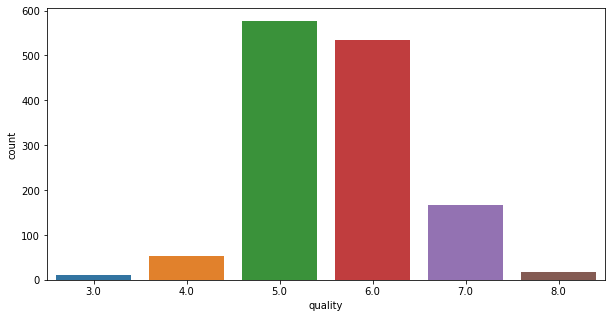

In [13]:
# Pregled broja instanci po pripadajućim klasama.
wineDataPandas = wineData.toPandas()
plt.subplots(figsize=(10,5))
sns.countplot(wineDataPandas['quality']);

In [14]:
wineDataPandas.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Pregled međusobnih zavisnosti atributa

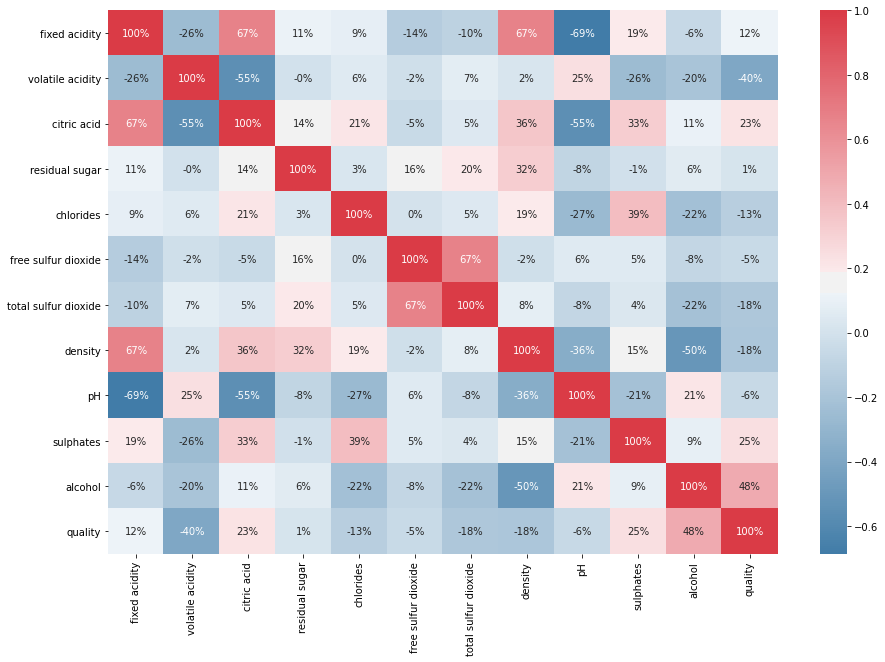

In [15]:
# Pregled međusobnih zavisnosti između atributa.
assembler = VectorAssembler(inputCols=wineData.columns, outputCol="features")
wineDataVector = assembler.transform(wineData).select("features")
correlationMatrix = Correlation.corr(wineDataVector, "features")
correlationMatrixToList = correlationMatrix.collect()[0][0].toArray().tolist()
plt.subplots(figsize=(15,10))
sns.heatmap(correlationMatrixToList, \
           xticklabels=wineData.columns, yticklabels=wineData.columns, \
           annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), fmt='.0%');

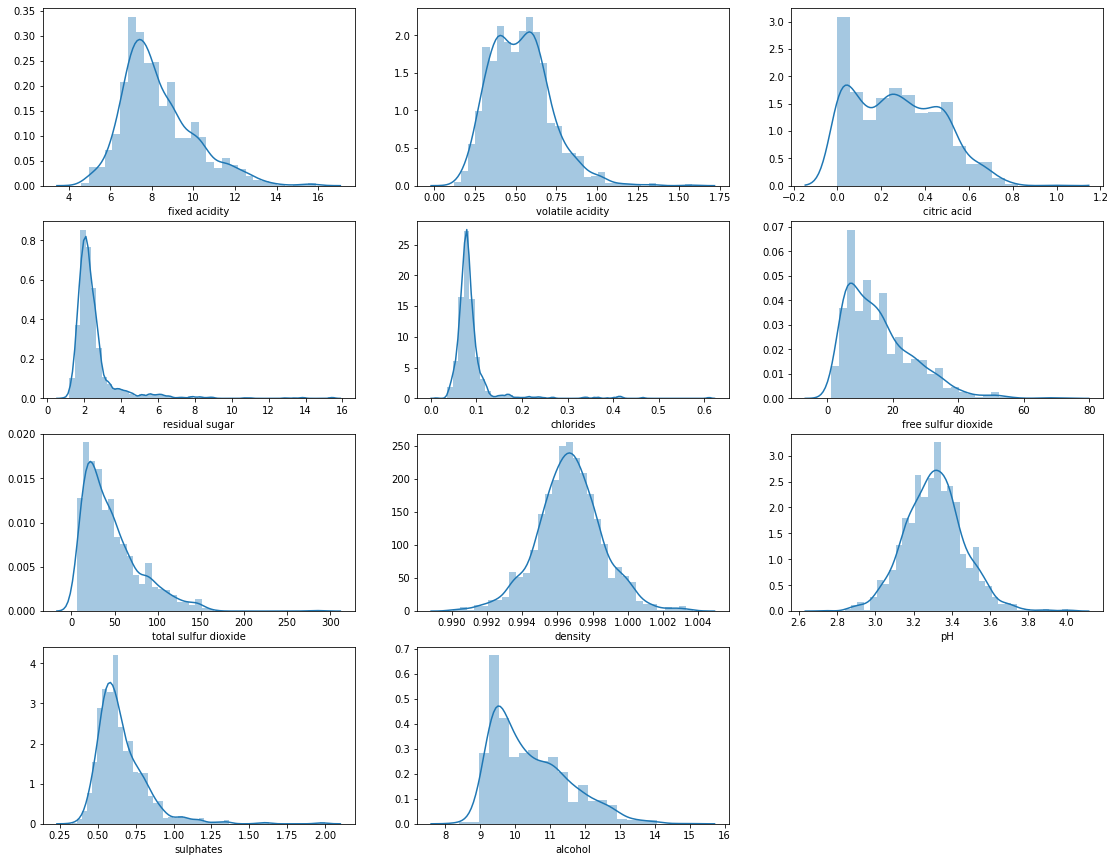

In [16]:
# Pregled distribucija vrednosti po atributima
fig = plt.figure(figsize=(19,15))
rows = 4
cols = 3
for i, col in enumerate(wineDataPandas.columns[:-1]):
  fig.add_subplot(rows, cols, i+1)
  sns.distplot(wineDataPandas[col])
plt.show()

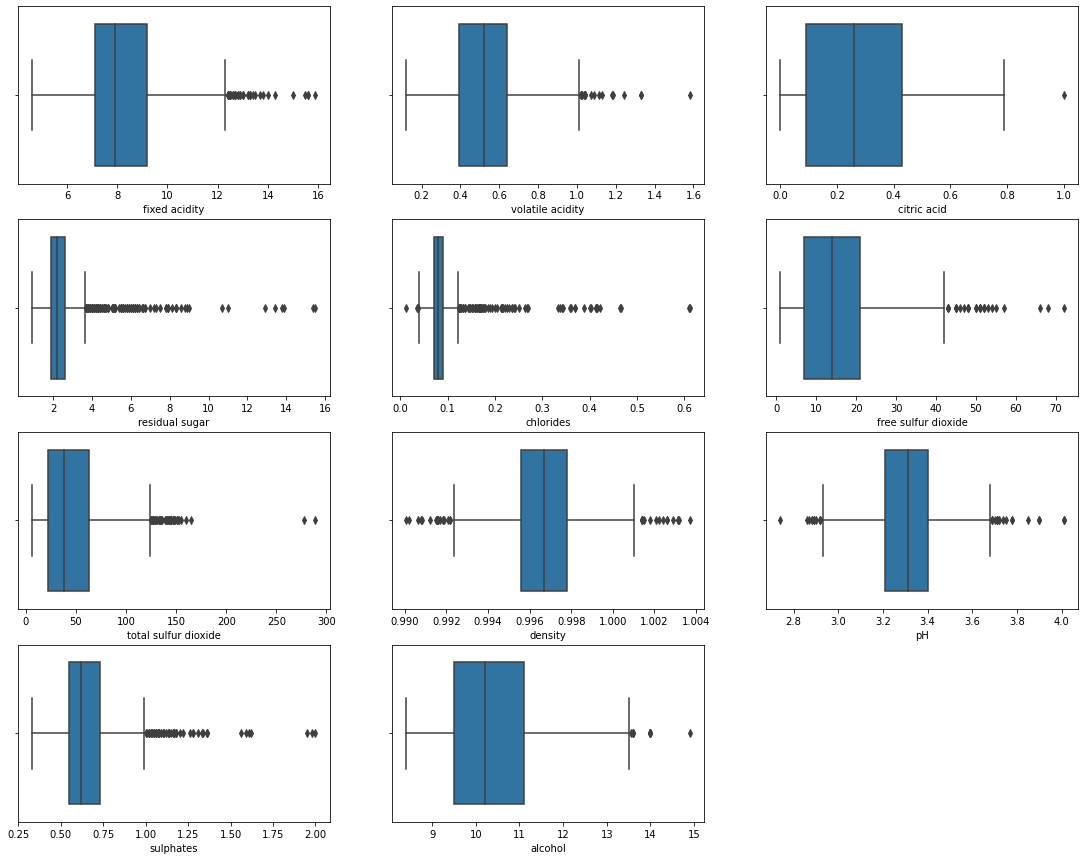

In [17]:
# Box-and-whisker
fig = plt.figure(figsize=(19,15))
rows = 4
cols = 3
for i, col in enumerate(wineDataPandas.columns[:-1]):
  fig.add_subplot(rows, cols, i+1)
  sns.boxplot(wineDataPandas[col])
plt.show()

In [18]:
# Izdvajanje klasnog atributa
wineDataNew = wineData.drop('quality')
wineDataNew.columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

### Skaliranje (Normalizacija)

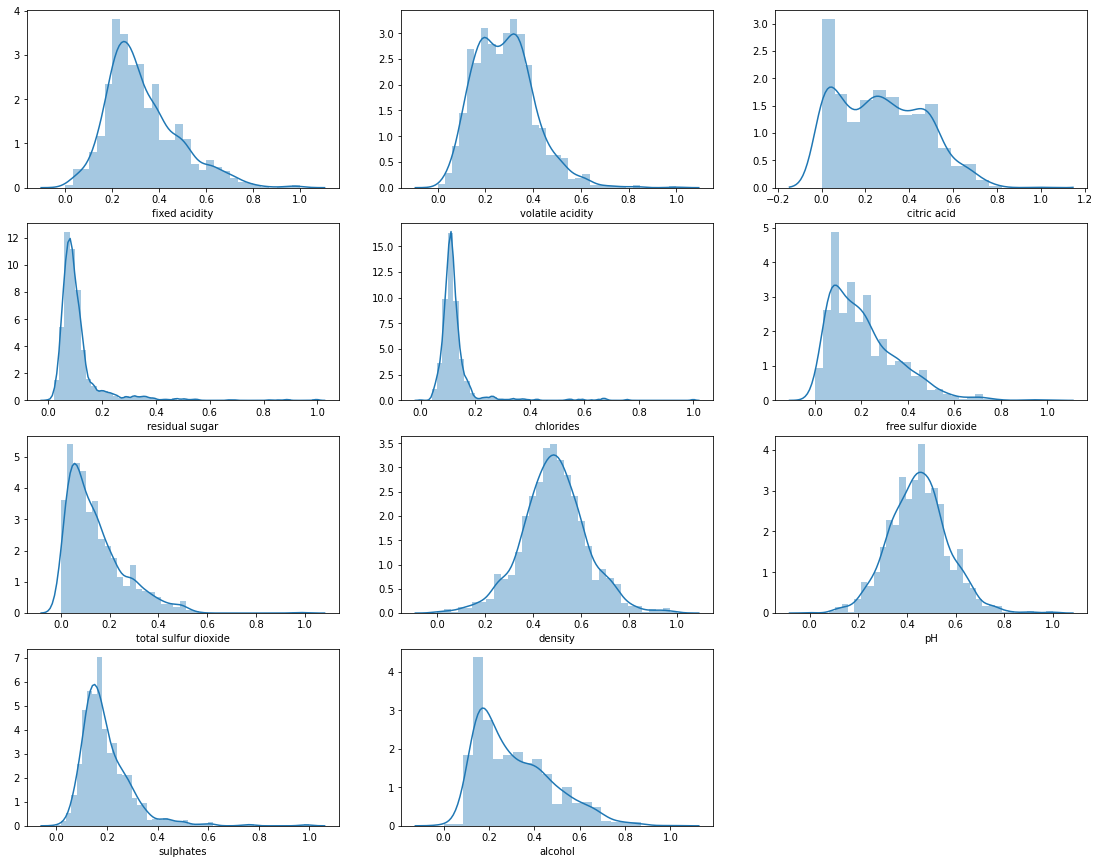

In [19]:
# Skaliranje na interval [0,1]
assembler = VectorAssembler(inputCols=wineDataNew.columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(wineDataNew)
scaledVectors = scalerModel.transform(wineDataNew)

# Vizualizacija skaliranih atributa
scaledVectorsList = []
for i, row in enumerate(scaledVectors.select('scaledFeatures').collect()):
  scaledVectorsList.append(row[0].tolist())
wineDF = pd.DataFrame(scaledVectorsList, columns=wineDataNew.columns)
fig = plt.figure(figsize=(19,15))
rows = 4
cols = 3
for i, col in enumerate(wineDF.columns):
  fig.add_subplot(rows, cols, i+1)
  sns.distplot(wineDF[col])
plt.show()

## K-means klasterovanje

### Izbor K vrednosti

In [20]:
# Izbor K vrednosti na osnovu Silhouette koeficijenta
silhouetteList = []
for k in range(2,13):
  kmeans = KMeans().setK(k).setSeed(1) \
                    .setFeaturesCol("features") \
                    .setPredictionCol("prediction")
  model = kmeans.fit(scaledVectors)
  predictions = model.transform(scaledVectors)
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  silhouetteList.append(silhouette)

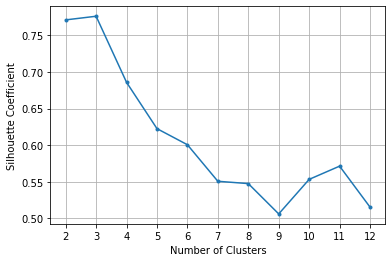

In [21]:
plt.plot(range(2,13), silhouetteList, '.-');
plt.xticks(range(2, 13))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.grid(True)
plt.show()

### Pipeline

In [22]:
kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol='prediction')
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(wineDataNew)
cluster = model.transform(wineDataNew)

In [23]:
cluster.select(['features', 'scaledFeatures', 'prediction']).show()

+--------------------+--------------------+----------+
|            features|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|[6.9,1.09,0.06,2....|[0.20353982300884...|         2|
|[10.4,0.34,0.58,3...|[0.51327433628318...|         1|
|[7.7,0.96,0.2,2.0...|[0.27433628318584...|         2|
|[12.6,0.39,0.49,2...|[0.70796460176991...|         1|
|[6.6,0.61,0.0,1.6...|[0.17699115044247...|         2|
|[5.9,0.44,0.0,1.6...|[0.11504424778761...|         2|
|[6.1,0.705,0.1,2....|[0.13274336283185...|         2|
|[5.6,0.5,0.09,2.3...|[0.08849557522123...|         2|
|[8.2,1.0,0.09,2.3...|[0.31858407079646...|         2|
|[9.8,1.24,0.34,2....|[0.46017699115044...|         0|
|[5.9,0.19,0.21,1....|[0.11504424778761...|         0|
|[13.7,0.415,0.68,...|[0.80530973451327...|         1|
|[7.8,0.57,0.09,2....|[0.28318584070796...|         2|
|[5.9,0.46,0.0,1.9...|[0.11504424778761...|         2|
|[9.2,0.54,0.31,2....|[0.40707964601769...|         1|
|[7.6,0.41

In [24]:
centers = model.stages[2].clusterCenters()
for center in centers:
  print(center)

[0.31584306 0.27625571 0.30380531 0.13869358 0.13132507 0.35562342
 0.28787121 0.52478786 0.42175923 0.1940897  0.22117843]
[0.48067951 0.18906862 0.47867612 0.11573399 0.1431227  0.14071188
 0.08438797 0.54202206 0.36311684 0.24168684 0.37189792]
[0.22756852 0.34761134 0.10825796 0.09235676 0.11331281 0.1758676
 0.10513699 0.4275612  0.52452551 0.16660147 0.32264313]


### Vizualizacija

In [25]:
clusterVectorsList = []
for i, row in enumerate(cluster.select(['scaledFeatures', 'prediction']).collect()):
  helper = row[0].tolist()
  helper.append(row[1])
  clusterVectorsList.append(helper)
  
columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', \
         'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', \
         'pH', 'sulphates', 'alcohol', 'prediction']
clusterWineDF = pd.DataFrame(clusterVectorsList, columns=columns)
clusterWineDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,prediction
0,0.203540,0.664384,0.06,0.082192,0.081803,0.154930,0.088339,0.347283,0.606299,0.059880,0.461538,2
1,0.513274,0.150685,0.58,0.191781,0.270451,0.070423,0.035336,0.508811,0.354331,0.221557,0.446154,1
2,0.274336,0.575342,0.20,0.075342,0.058431,0.197183,0.190813,0.398678,0.488189,0.065868,0.384615,2
3,0.707965,0.184932,0.49,0.109589,0.113523,0.098592,0.049470,0.670338,0.259843,0.293413,0.292308,1
4,0.176991,0.335616,0.00,0.047945,0.095159,0.042254,0.007067,0.285609,0.464567,0.023952,0.307692,2


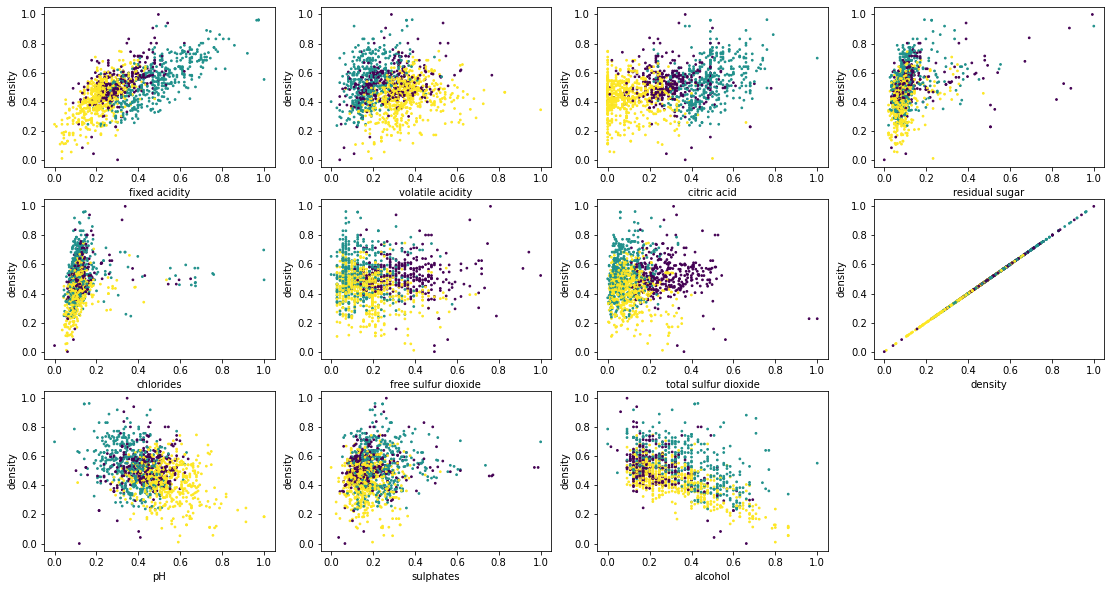

In [26]:
rows = 3
cols = 4
fig = plt.figure(figsize=(19,10))
for i, col in enumerate(clusterWineDF.columns[:-1]):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.scatter(clusterWineDF[col], clusterWineDF['density'], c=clusterWineDF['prediction'], s=3)
    plt.xlabel(col)
    plt.ylabel("density")
plt.show()

### Vizualizacija pomoću PCA

In [27]:
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(cluster)
pcaResults = pcaModel.transform(cluster).select(['pcaFeatures', 'prediction'])
pcaResults.show(5, truncate=False)

+-----------------------------------------------------------------+----------+
|pcaFeatures                                                      |prediction|
+-----------------------------------------------------------------+----------+
|[0.1170565295501453,-0.024708017075311395,0.0782738567449873]    |2         |
|[-0.6873874905824338,-0.19332736405317402,0.12766046912772344]   |1         |
|[-0.08983047620067625,0.04604086549228259,0.16671455010690667]   |2         |
|[-0.8025671464620434,0.02207532119570496,0.0382379800458953]     |1         |
|[0.05866028525679711,-0.042740802807731154,-0.023599124123923843]|2         |
+-----------------------------------------------------------------+----------+
only showing top 5 rows



In [28]:
pcaVectorsList = []
for i, row in enumerate(pcaResults.select(['pcaFeatures', 'prediction']).collect()):
  helper = row[0].tolist()
  helper.append(row[1])
  pcaVectorsList.append(helper)
pcaWineDF = pd.DataFrame(pcaVectorsList, columns=['pcaComponent_1', 'pcaComponent_2', 'pcaComponent_3', 'prediction'])
pcaWineDF.head()

,pcaComponent_1,pcaComponent_2,pcaComponent_3,prediction
0,0.117057,-0.024708,0.078274,2
1,-0.687387,-0.193327,0.127660,1
2,-0.089830,0.046041,0.166715,2
3,-0.802567,0.022075,0.038238,1
4,0.058660,-0.042741,-0.023599,2


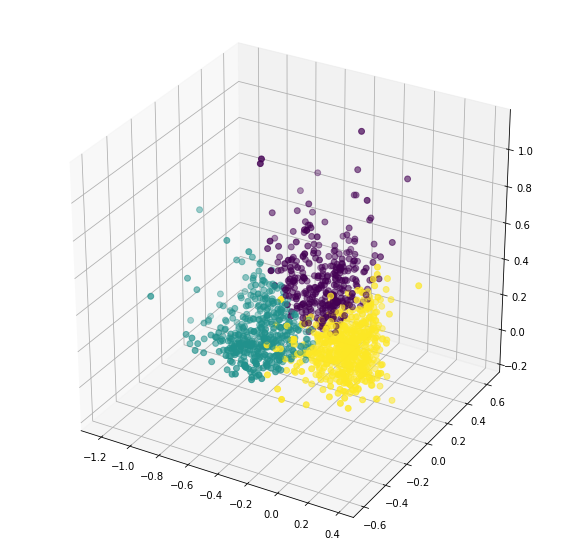

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = pcaWineDF['pcaComponent_1']
y = pcaWineDF['pcaComponent_2']
z = pcaWineDF['pcaComponent_3']
c = pcaWineDF['prediction']
ax.scatter(x,y,z,c=c,s=35)
plt.show();

### Čuvanje modela i pipeline-a

In [32]:
model.save("/content/gdrive/My Drive/Colab Notebooks/model")
pipeline.save("/content/gdrive/My Drive/Colab Notebooks/pipeline")

# Model i pipeline možemo kasnije učitati
# NAPOMENA: Naredne linije su stavljene pod komentar
# loadModel = PipelineModel.load("/content/drive/My Drive/Colab Notebooks/model")
# loadPipeline = Pipeline.load("/content/drive/My Drive/Colab Notebooks/model")

In [33]:
# Uklanjanje modela i pipeline-a sa Google Drive-a
!rm -r gdrive/'My Drive'/'Colab Notebooks'/model
!rm -r gdrive/'My Drive'/'Colab Notebooks'/pipeline